In [2]:
import numpy as np
import os
import random
import time
from glob import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from google.colab import drive
#drive.mount('/content/drive')

mnist_data = np.load('mnist_train.npz')
X_train_original = mnist_data['train_images']
y_train_original = mnist_data['train_labels']

FONT_PATHS = glob('fonts/**/*.ttf', recursive=True)

IMAGE_SIZE = (28, 28)
FONT_SIZE = 25

# 색상 팔레트 및 라벨 인코딩
RAINBOW_NAMES = ['RED', 'ORANGE', 'YELLOW', 'GREEN', 'BLUE', 'INDIGO', 'VIOLET']
RAINBOW_COLORS_RGB = [
    (255, 0, 0), (255, 127, 0), (255, 255, 0), (0, 255, 0),
    (0, 0, 255), (75, 0, 130), (148, 0, 211)
]
COLOR_TO_LABEL = {name: i for i, name in enumerate(RAINBOW_NAMES)}
LABEL_TO_COLOR_NAME = {i: name for i, name in enumerate(RAINBOW_NAMES)}
print("\n색상 라벨 인코딩 설정 완료.")
print(COLOR_TO_LABEL)


색상 라벨 인코딩 설정 완료.
{'RED': 0, 'ORANGE': 1, 'YELLOW': 2, 'GREEN': 3, 'BLUE': 4, 'INDIGO': 5, 'VIOLET': 6}


### 색상 함수

In [5]:
def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 (RGB, 이름) 튜플을 반환합니다."""
    idx = np.random.randint(0, len(RAINBOW_COLORS_RGB))
    return RAINBOW_COLORS_RGB[idx], RAINBOW_NAMES[idx]

def colorize_digit_with_threshold(digit_image_pil, fg_color, bg_color):
    """PIL 이미지에 경계선 번짐 없이 선명한 전경/배경 색을 적용합니다."""
    # 그레이스케일 이미지로 변환하여 마스크 생성
    mask = digit_image_pil.convert('L').point(lambda p: 255 if p > 128 else 0)

    # 배경색으로 채워진 새 RGB 이미지 생성
    final_image = Image.new("RGB", digit_image_pil.size, bg_color)

    # 마스크를 이용해 전경색 붙여넣기
    final_image.paste(fg_color, mask=mask)
    return final_image

# --- 이미지 소스 관련 함수 ---
# 원본 MNIST 이미지를 숫자별로 미리 분류하여 딕셔너리에 저장 (효율성 증대)
mnist_images_by_label = {i: [] for i in range(10)}
for img, lbl in zip(X_train_original, y_train_original):
    mnist_images_by_label[lbl].append(img)

def get_mnist_image_for_digit(digit):
    """특정 숫자에 해당하는 원본 MNIST 이미지를 랜덤하게 PIL 이미지로 반환합니다."""
    images_list = mnist_images_by_label[digit]
    random_image_np = random.choice(images_list)
    return Image.fromarray(random_image_np.astype('uint8')) # 'L': 8-bit grayscale

def generate_digit_image_from_font(digit, font_path):
    """주어진 폰트로 특정 숫자 이미지를 생성하여 PIL 이미지로 반환합니다."""
    image = Image.new("L", IMAGE_SIZE, 0) 
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, FONT_SIZE)

    bbox = draw.textbbox((0, 0), str(digit), font=font)
    text_width = bbox[2] - bbox[0]
    position = ((IMAGE_SIZE[0] - text_width) // 2, -3) # 위치 미세 조정
    draw.text(position, str(digit), fill=255, font=font) 
    return image

### 데이터 생성 함수

In [6]:
def create_colored_dataset(num_samples, mnist_ratio=0.7):
    """
    지정된 개수만큼 컬러 데이터셋을 생성합니다.
    - num_samples: 생성할 샘플의 총 개수
    - mnist_ratio: 원본 MNIST 이미지 소스를 사용할 비율 (나머지는 폰트 사용)
    """
    X_data, y_data_digit, y_data_fg, y_data_bg = [], [], [], []

    print(f"\n총 {num_samples}개의 데이터 생성을 시작합니다 (MNIST 비율: {mnist_ratio*100}%)")
    start_time = time.time()

    for _ in tqdm(range(num_samples)):
        # 1. 라벨 생성
        digit_label = random.randint(0, 9)
        fg_color_rgb, fg_name = get_random_rainbow_color()
        bg_color_rgb, bg_name = get_random_rainbow_color()
        while fg_color_rgb == bg_color_rgb:
            bg_color_rgb, bg_name = get_random_rainbow_color()
        fg_label = COLOR_TO_LABEL[fg_name]
        bg_label = COLOR_TO_LABEL[bg_name]

        # 2. 베이스 이미지 생성 (MNIST or Font)
        if random.random() < mnist_ratio:
            base_image_pil = get_mnist_image_for_digit(digit_label)
        else:
            font_path = random.choice(FONT_PATHS)
            base_image_pil = generate_digit_image_from_font(digit_label, font_path)

        # 3. 이미지 색칠하기
        colorized_image_pil = colorize_digit_with_threshold(base_image_pil, fg_color_rgb, bg_color_rgb)

        # 4. 전처리 및 저장 (0.0 ~ 1.0 정규화)
        image_np_normalized = np.array(colorized_image_pil) / 255.0

        X_data.append(image_np_normalized)
        y_data_digit.append(digit_label)
        y_data_fg.append(fg_label)
        y_data_bg.append(bg_label)

    end_time = time.time()
    print(f"데이터 생성 완료! (소요 시간: {end_time - start_time:.2f}초)")

    # 최종 Numpy 배열로 변환
    return (np.array(X_data, dtype=np.float32),
            np.array(y_data_digit, dtype=np.int32),
            np.array(y_data_fg, dtype=np.int32),
            np.array(y_data_bg, dtype=np.int32))

### 데이터 생성

In [ ]:
X_train_gen, y_train_digit, y_train_fg, y_train_bg = create_colored_dataset(
    num_samples=60000, mnist_ratio=0.7
)

# 테스트용 1만개 (MNIST 70% : 폰트 30%)
X_test_gen, y_test_digit, y_test_fg, y_test_bg = create_colored_dataset(
    num_samples=10000, mnist_ratio=0.7
)

print("\n--- 생성된 데이터셋 Shape ---")
print(f"Train X: {X_train_gen.shape}, Train y_digit: {y_train_digit.shape}")
print(f"Test X: {X_test_gen.shape},  Test y_digit: {y_test_digit.shape}")


SAVE_PATH_TRAIN = 'Data/colored_mnist_train.npz'
SAVE_PATH_TEST = 'Data/colored_mnist_test.npz'

print("\n생성된 데이터셋을 NPZ 파일로 저장합니다...")
np.savez_compressed(
    SAVE_PATH_TRAIN,
    images=X_train_gen,
    labels_digit=y_train_digit,
    labels_fg=y_train_fg,
    labels_bg=y_train_bg
)
np.savez_compressed(
    SAVE_PATH_TEST,
    images=X_test_gen,
    labels_digit=y_test_digit,
    labels_fg=y_test_fg,
    labels_bg=y_test_bg
)
print(f"학습 데이터 저장 완료: {SAVE_PATH_TRAIN}")
print(f"테스트 데이터 저장 완료: {SAVE_PATH_TEST}")


총 600000개의 데이터 생성을 시작합니다 (MNIST 비율: 70.0%)


  0%|          | 0/600000 [00:00<?, ?it/s]

데이터 생성 완료! (소요 시간: 126.00초)

총 100000개의 데이터 생성을 시작합니다 (MNIST 비율: 70.0%)


  0%|          | 0/100000 [00:00<?, ?it/s]

데이터 생성 완료! (소요 시간: 25.49초)

--- 생성된 데이터셋 Shape ---
Train X: (600000, 28, 28, 3), Train y_digit: (600000,)
Test X: (100000, 28, 28, 3),  Test y_digit: (100000,)

생성된 데이터셋을 NPZ 파일로 저장합니다...
학습 데이터 저장 완료: Data/colored_mnist_train.npz
테스트 데이터 저장 완료: Data/colored_mnist_test.npz


### 데이터 생성 검증

In [7]:
# 저장된 학습 데이터 불러오기
verify_data = np.load(SAVE_PATH_TRAIN)
X_verify = verify_data['images']
y_digit_verify = verify_data['labels_digit']
y_fg_verify = verify_data['labels_fg']
y_bg_verify = verify_data['labels_bg']

# 5개의 랜덤 샘플 시각화
plt.figure(figsize=(15, 4))
for i in range(5):
    idx = random.randint(0, len(X_verify) - 1)

    plt.subplot(1, 5, i + 1)
    plt.imshow(X_verify[idx])

    digit = y_digit_verify[idx]
    fg_color_name = LABEL_TO_COLOR_NAME[y_fg_verify[idx]]
    bg_color_name = LABEL_TO_COLOR_NAME[y_bg_verify[idx]]

    plt.title(f"Digit: {digit}\nFG: {fg_color_name}, BG: {bg_color_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'SAVE_PATH_TRAIN' is not defined

## 증강적용 데이터셋 생성

=== 총 5가지 모드(['shift', 'rotate', 'scale', 'shear', 'all']) 데이터셋 생성을 시작합니다 ===

Example Mode: shift
   -> [SHIFT] 모드 생성 중... (40000개)
   -> [SHIFT] 모드 생성 중... (10000개)
   [저장 완료] Train: Data/colored_mnist_train_shift.npz / Valid: Data/colored_mnist_valid_shift.npz

Example Mode: rotate
   -> [ROTATE] 모드 생성 중... (40000개)
   -> [ROTATE] 모드 생성 중... (10000개)
   [저장 완료] Train: Data/colored_mnist_train_rotate.npz / Valid: Data/colored_mnist_valid_rotate.npz

Example Mode: scale
   -> [SCALE] 모드 생성 중... (40000개)
   -> [SCALE] 모드 생성 중... (10000개)
   [저장 완료] Train: Data/colored_mnist_train_scale.npz / Valid: Data/colored_mnist_valid_scale.npz

Example Mode: shear
   -> [SHEAR] 모드 생성 중... (40000개)
   -> [SHEAR] 모드 생성 중... (10000개)
   [저장 완료] Train: Data/colored_mnist_train_shear.npz / Valid: Data/colored_mnist_valid_shear.npz

Example Mode: all
   -> [ALL] 모드 생성 중... (40000개)
   -> [ALL] 모드 생성 중... (10000개)
   [저장 완료] Train: Data/colored_mnist_train_all.npz / Valid: Data/colored_mnist_valid_all.n

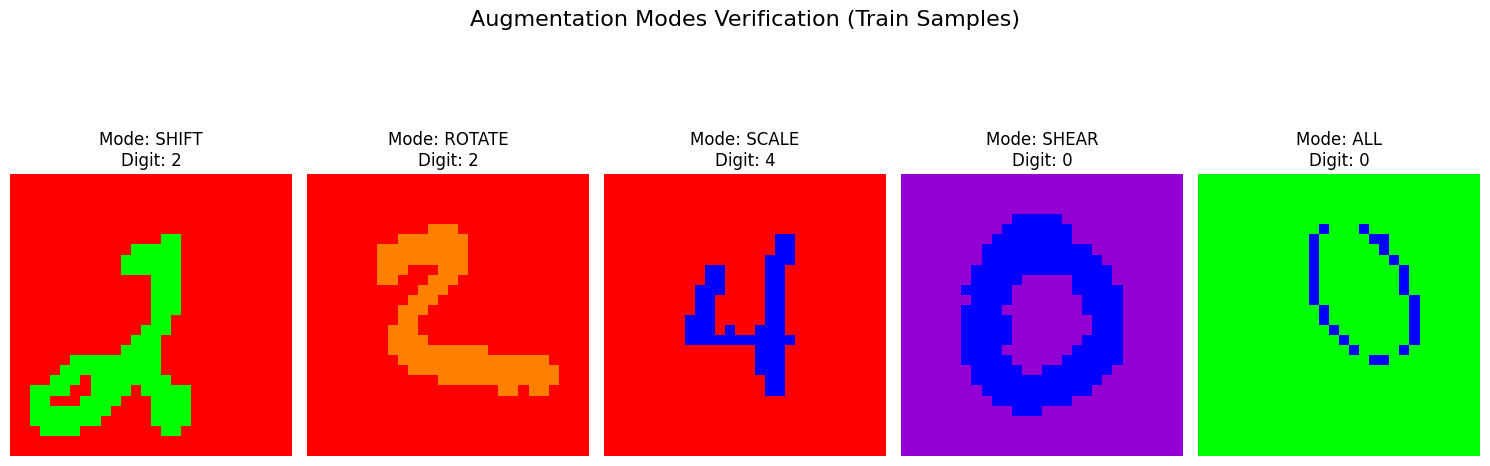

In [13]:
# --- 기존 코드에 이어서 실행하세요 ---

def apply_specific_augmentation(base_image, mode='all'):
    """
    모드에 따라 특정 증강 기법을 적용합니다.
    mode: 'shift', 'rotate', 'scale', 'shear', 'all'
    """
    w, h = base_image.size
    img = base_image

    # 랜덤 파라미터 준비
    angle = random.uniform(-15, 15)       # 회전
    scale = random.uniform(0.8, 1.20)    # 스케일
    shear = random.uniform(-0.2, 0.2)     # 기울임
    shift_x = random.randint(-4, 4)       # 이동 (좌우 5픽셀)
    shift_y = random.randint(-4, 4)       # 이동 (상하 5픽셀)

    # 1. Shift (이동)
    if mode in ['shift', 'all']:
        # (1, 0, -dx, 0, 1, -dy) 행렬 사용
        img = img.transform(
            (w, h), Image.AFFINE, 
            (1, 0, -shift_x, 0, 1, -shift_y), 
            resample=Image.BICUBIC
        )

    # 2. Rotate (회전)
    if mode in ['rotate', 'all']:
        img = img.rotate(angle, resample=Image.BICUBIC, expand=False)

    # 3. Shear (기울임)
    if mode in ['shear', 'all']:
        img = img.transform(
            (w, h), Image.AFFINE, 
            (1, -shear, 0, 0, 1, 0), 
            resample=Image.BICUBIC
        )

    # 4. Scale (확대/축소)
    if mode in ['scale', 'all']:
        new_w, new_h = int(w * scale), int(h * scale)
        img_resized = img.resize((new_w, new_h), resample=Image.BICUBIC)
        
        final_canvas = Image.new("L", (w, h), 0)
        paste_x = (w - new_w) // 2
        paste_y = (h - new_h) // 2

        if scale > 1.0: # 확대 시 크롭
            crop_x = (new_w - w) // 2
            crop_y = (new_h - h) // 2
            img_cropped = img_resized.crop((crop_x, crop_y, crop_x + w, crop_y + h))
            final_canvas.paste(img_cropped, (0, 0))
        else: # 축소 시 중앙 배치 (이미 Shift가 적용되었으면 그 상태에서 축소됨)
            final_canvas.paste(img_resized, (paste_x, paste_y))
        
        img = final_canvas

    return img

def create_dataset_by_mode(num_samples, mode, mnist_ratio=0.7):
    """
    지정된 mode('shift', 'rotate' 등)로 데이터를 생성합니다.
    """
    X_data, y_digit, y_fg, y_bg = [], [], [], []
    
    print(f"   -> [{mode.upper()}] 모드 생성 중... ({num_samples}개)")
    
    for _ in range(num_samples): # tqdm은 메인 루프에서 관리하거나 생략
        # 기본 데이터 생성
        d_label = random.randint(0, 9)
        fg_rgb, fg_name = get_random_rainbow_color()
        bg_rgb, bg_name = get_random_rainbow_color()
        while fg_rgb == bg_rgb:
            bg_rgb, bg_name = get_random_rainbow_color()
            
        if random.random() < mnist_ratio:
            base_img = get_mnist_image_for_digit(d_label)
        else:
            f_path = random.choice(FONT_PATHS)
            base_img = generate_digit_image_from_font(d_label, f_path)

        # --- [핵심] 모드별 증강 적용 ---
        base_img = apply_specific_augmentation(base_img, mode=mode)
        # ---------------------------

        colored_img = colorize_digit_with_threshold(base_img, fg_rgb, bg_rgb)
        
        X_data.append(np.array(colored_img) / 255.0)
        y_digit.append(d_label)
        y_fg.append(COLOR_TO_LABEL[fg_name])
        y_bg.append(COLOR_TO_LABEL[bg_name])

    return (np.array(X_data, dtype=np.float32), 
            np.array(y_digit, dtype=np.int32), 
            np.array(y_fg, dtype=np.int32), 
            np.array(y_bg, dtype=np.int32))


# --- 메인 실행 루프 ---
aug_modes = ['shift', 'rotate', 'scale', 'shear', 'all']
DATA_DIR = 'Data'

print(f"=== 총 5가지 모드({aug_modes}) 데이터셋 생성을 시작합니다 ===")

for mode in aug_modes:
    print(f"\nExample Mode: {mode}")
    
    # 1. 학습용 (40,000개)
    X_tr, y_tr_d, y_tr_fg, y_tr_bg = create_dataset_by_mode(40000, mode)
    save_name_tr = f"{DATA_DIR}/colored_mnist_train_{mode}.npz"
    np.savez_compressed(save_name_tr, images=X_tr, labels_digit=y_tr_d, labels_fg=y_tr_fg, labels_bg=y_tr_bg)
    
    # 2. 검증용 (10,000개)
    X_val, y_val_d, y_val_fg, y_val_bg = create_dataset_by_mode(10000, mode)
    save_name_val = f"{DATA_DIR}/colored_mnist_valid_{mode}.npz"
    np.savez_compressed(save_name_val, images=X_val, labels_digit=y_val_d, labels_fg=y_val_fg, labels_bg=y_val_bg)
    
    print(f"   [저장 완료] Train: {save_name_tr} / Valid: {save_name_val}")

print("\n=== 모든 데이터셋 생성 완료! ===")

# --- 시각화 (각 모드별 샘플 확인) ---
plt.figure(figsize=(15, 6))
plt.suptitle("Augmentation Modes Verification (Train Samples)", fontsize=16)

for i, mode in enumerate(aug_modes):
    # 각 모드별 저장된 파일 다시 로드해서 확인
    data = np.load(f"{DATA_DIR}/colored_mnist_train_{mode}.npz")
    img = data['images'][0] # 첫 번째 이미지
    lbl = data['labels_digit'][0]
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Mode: {mode.upper()}\nDigit: {lbl}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 생성 데이터 확인

=== 각 증강 모드별 랜덤 샘플 8개 시각화 ===

>> Loading Mode: SHIFT...


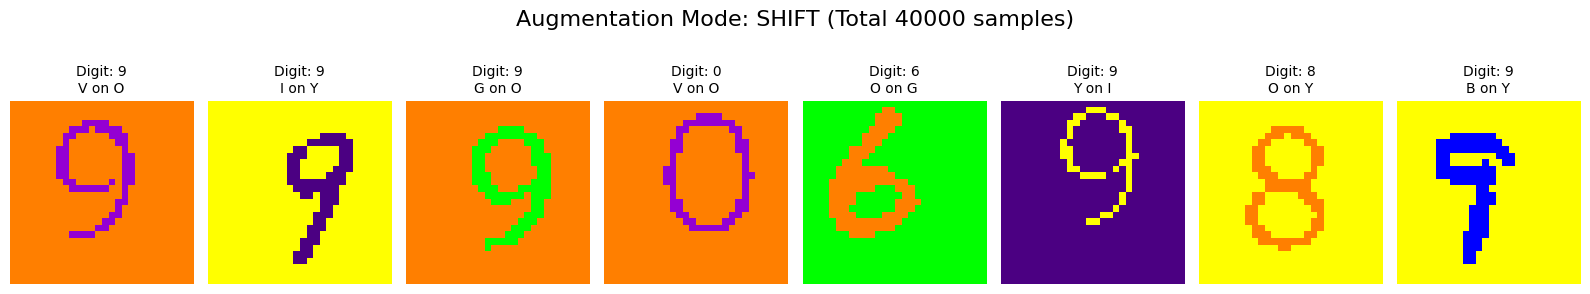


>> Loading Mode: ROTATE...


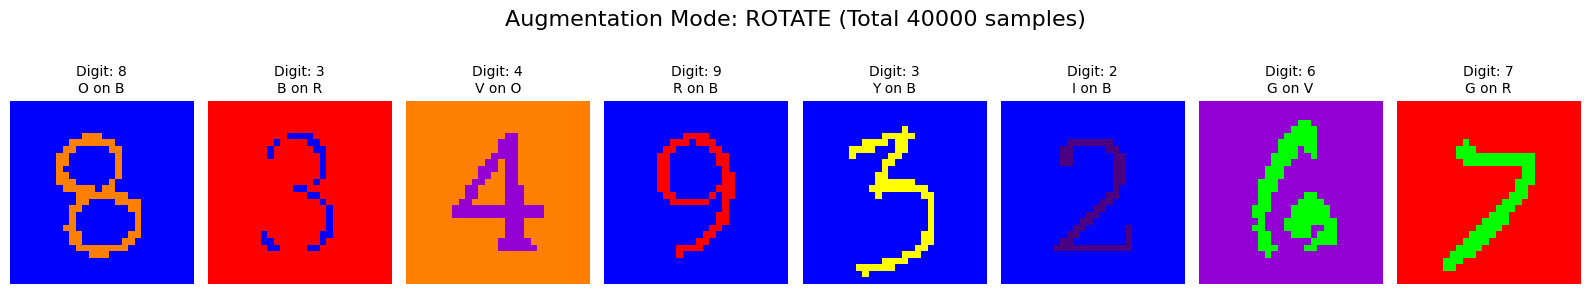


>> Loading Mode: SCALE...


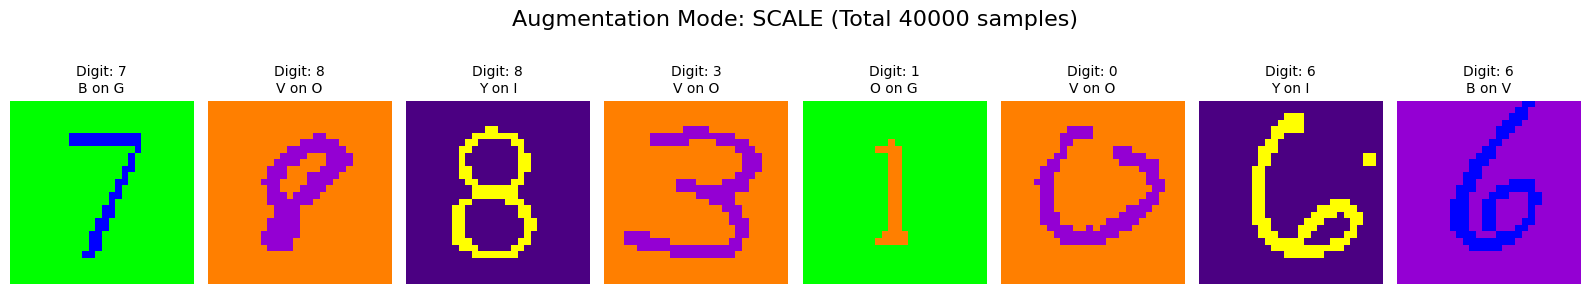


>> Loading Mode: SHEAR...


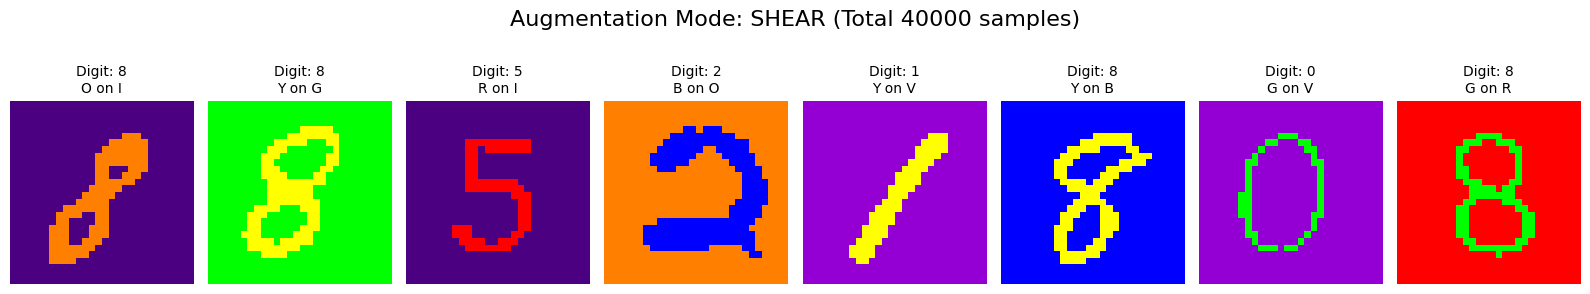


>> Loading Mode: ALL...


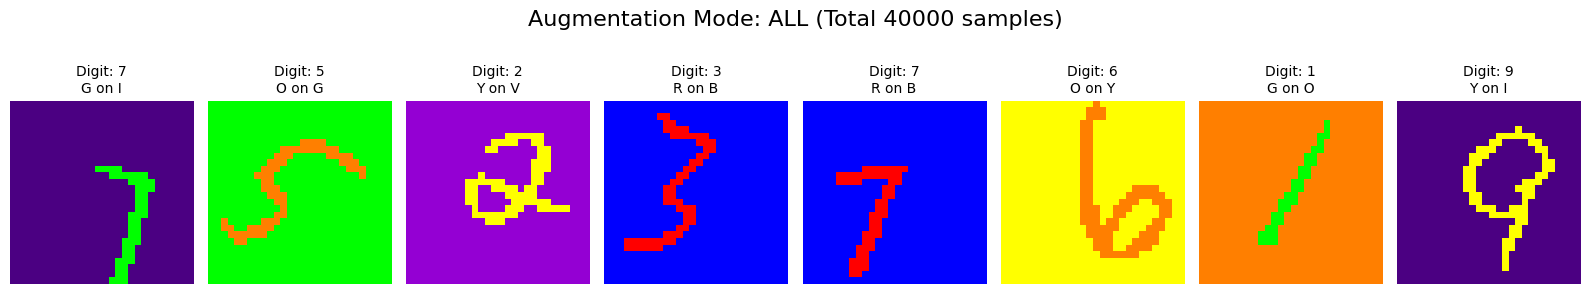

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# --- 설정 ---
DATA_DIR = 'Data'
AUG_MODES = ['shift', 'rotate', 'scale', 'shear', 'all']
SAMPLES_TO_SHOW = 8  # 각 모드별로 보여줄 샘플 개수

# 색상 이름 매핑 (라벨을 보기 좋게 표시하기 위함)
RAINBOW_NAMES = ['RED', 'ORANGE', 'YELLOW', 'GREEN', 'BLUE', 'INDIGO', 'VIOLET']
LABEL_TO_COLOR_NAME = {i: name for i, name in enumerate(RAINBOW_NAMES)}

def visualize_augmentation_samples():
    # 데이터 폴더 확인
    if not os.path.exists(DATA_DIR):
        print(f"오류: '{DATA_DIR}' 폴더를 찾을 수 없습니다. 데이터를 먼저 생성해주세요.")
        return

    print(f"=== 각 증강 모드별 랜덤 샘플 {SAMPLES_TO_SHOW}개 시각화 ===")

    for mode in AUG_MODES:
        # 파일 경로 (학습용 데이터 기준)
        filepath = os.path.join(DATA_DIR, f'colored_mnist_train_{mode}.npz')
        
        if not os.path.exists(filepath):
            print(f"\n주의: {filepath} 파일을 찾을 수 없어 건너뜁니다.")
            continue
            
        print(f"\n>> Loading Mode: {mode.upper()}...")
        try:
            # 데이터 로드
            data = np.load(filepath)
            images = data['images']
            labels_d = data['labels_digit']
            labels_fg = data['labels_fg']
            labels_bg = data['labels_bg']
            num_total = len(images)
            
            # 시각화 설정 (1줄에 SAMPLES_TO_SHOW 만큼 표시)
            fig, axes = plt.subplots(1, SAMPLES_TO_SHOW, figsize=(SAMPLES_TO_SHOW * 2, 3))
            fig.suptitle(f"Augmentation Mode: {mode.upper()} (Total {num_total} samples)", fontsize=16, y=1.05)
            
            if SAMPLES_TO_SHOW == 1: axes = [axes] # 샘플이 1개일 경우 배열 처리

            for i, ax in enumerate(axes):
                # 랜덤 인덱스 선택
                idx = random.randint(0, num_total - 1)
                
                img = images[idx]
                digit = labels_d[idx]
                # 공간 절약을 위해 색상 이름의 첫 글자만 표시 (예: RED -> R)
                fg_name = LABEL_TO_COLOR_NAME[labels_fg[idx]][0]
                bg_name = LABEL_TO_COLOR_NAME[labels_bg[idx]][0]

                ax.imshow(img)
                # 제목: 숫자 | 전경색(첫글자) on 배경색(첫글자)
                ax.set_title(f"Digit: {digit}\n{fg_name} on {bg_name}", fontsize=10)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"오류 발생 ({mode}): {e}")

# --- 실행 ---
visualize_augmentation_samples()